# LSS-CFAR

## third-party implementation

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from loguru import logger

def triangular_toeplitz_multiply(u, v):
    n = u.shape[-1]
    u_expand = F.pad(u, (0, n))
    v_expand = F.pad(v, (0, n))
    u_f = torch.fft.rfft(u_expand, n=2*n, dim=-1)
    v_f = torch.fft.rfft(v_expand, n=2*n, dim=-1)
    uv_f = u_f * v_f
    output = torch.fft.irfft(uv_f, n=2*n, dim=-1)[..., :n]
    return output

def krylov(L, A, b):
    """ Compute the Krylov matrix (b, Ab, A^2b, ...) using the squaring trick.  """

    x = b.unsqueeze(-1) # (..., N, 1)
    A_ = A

    done = L == 1
    while not done:
        # Save memory on last iteration
        l = x.shape[-1]
        if L - l <= l:
            done = True
            _x = x[..., :L-l]
        else: _x = x

        _x = A_ @ _x
        x = torch.cat([x, _x], dim=-1) # there might be a more efficient way of ordering axes
        if not done: A_ = A_ @ A_

    assert x.shape[-1] == L

    x = x.contiguous()
    return x


def hippo(N):
    """ Return the HiPPO-LegT state matrices """
    Q = np.arange(N, dtype=np.float64)
    R = (2*Q + 1) ** .5
    j, i = np.meshgrid(Q, Q)
    A = R[:, None] * np.where(i < j, (-1.)**(i-j), 1) * R[None, :]
    B = R[:, None]
    A = -A
    return A, B

class AdaptiveTransition(nn.Module):
    """ General class which supports discretizing a state space equation x' = Ax + Bu
    Different subclasses can compute the forward and inverse mults in different ways
    This particular method is specialized to the HiPPO-LegT transition for simplicity
    """

    def __init__(self, N):
        """
        N: State space order, size of HiPPO matrix
        """

        super().__init__()
        self.N = N

        A, B = hippo(N)
        A = torch.as_tensor(A, dtype=torch.float)
        B = torch.as_tensor(B, dtype=torch.float)[:, 0]
        self.register_buffer('A', A)
        self.register_buffer('B', B)

        # Register some common buffers
        # (helps make sure every subclass has access to them on the right device)
        I = torch.eye(N)
        self.register_buffer('I', I)


    def forward_mult(self, u, delta):
        """ Computes (I + delta A) u
        A: (n, n)
        u: (..., n)
        delta: (...) or scalar
        output: (..., n)
        """
        raise NotImplementedError

    def inverse_mult(self, u, delta): # TODO swap u, delta everywhere
        """ Computes (I - d A)^-1 u """
        raise NotImplementedError

    def forward_diff(self, d, u, v):
        """ Computes the 'forward diff' or Euler update rule: (I - d A)^-1 u + d B v
        d: (...)
        u: (..., N)
        v: (...)
        """
        v = d * v
        v = v.unsqueeze(-1) * self.B
        x = self.forward_mult(u, d)
        x = x + v
        return x

    def backward_diff(self, d, u, v):
        """ Computes the 'forward diff' or Euler update rule: (I - d A)^-1 u + d (I - d A)^-1 B v
        d: (...)
        u: (..., N)
        v: (...)
        """
        v = d * v
        v = v.unsqueeze(-1) * self.B
        x = u + v
        x = self.inverse_mult(x, d)
        return x

    def bilinear(self, dt, u, v, alpha=.5):
        """ Computes the bilinear (aka trapezoid or Tustin's) update rule.
        (I - d/2 A)^-1 (I + d/2 A) u + d B (I - d/2 A)^-1 B v
        dt: (...)
        u: (..., N)
        v: (...)
        """
        x = self.forward_mult(u, (1-alpha)*dt)
        v = dt * v
        v = v.unsqueeze(-1) * self.B
        x = x + v
        x = self.inverse_mult(x, (alpha)*dt)
        return x

    def gbt_A(self, dt, alpha=.5):
        """ Compute the transition matrices associated with bilinear transform
        dt: (...)
        returns: (..., N, N)
        """
        # solve (N, ...) parallel problems of size N
        dims = len(dt.shape)
        I = self.I.view([self.N] + [1]*dims + [self.N])
        A = self.bilinear(dt, I, dt.new_zeros(*dt.shape), alpha=alpha) # (N, ..., N)
        A = rearrange(A, 'n ... m -> ... m n', n=self.N, m=self.N)
        return A

    def gbt_B(self, dt, alpha=.5):
        B = self.bilinear(dt, dt.new_zeros(*dt.shape, self.N), dt.new_ones(1), alpha=alpha) # (..., N)
        return B


class LegTTransitionDense(AdaptiveTransition):
    """ Slower and memory inefficient version via manual matrix mult/inv """

    def forward_mult(self, u, delta, transpose=False):
        if isinstance(delta, torch.Tensor):
            delta = delta.unsqueeze(-1)
        A_ = self.A.transpose(-1, -2) if transpose else self.A
        x = (A_ @ u.unsqueeze(-1)).squeeze(-1)
        x = u + delta * x

        return x

    def inverse_mult(self, u, delta, transpose=False):
        """ Computes (I - d A)^-1 u """

        if isinstance(delta, torch.Tensor):
            delta = delta.unsqueeze(-1).unsqueeze(-1)
        _A = self.I - delta * self.A
        if transpose: _A = _A.transpose(-1, -2)

        # x = torch.linalg.solve(_A, u.unsqueeze(-1)).squeeze(-1) # this can run out of memory
        xs = []
        for _A_, u_ in zip(*torch.broadcast_tensors(_A, u.unsqueeze(-1))):
            x_ = torch.linalg.solve(_A_, u_[...,:1]).squeeze(-1)
            xs.append(x_)
        x = torch.stack(xs, dim=0)

        return x


class StateSpace(nn.Module):
    """ Computes a state space layer.
    Simulates the state space ODE
    x' = Ax + Bu
    y = Cx + Du
    - A single state space computation maps a 1D function u to a 1D function y
    - For an input of H features, each feature is independently run through the state space
      with a different timescale / sampling rate / discretization step size.
    """
    def __init__(
            self,
            d, # hidden dimension, also denoted H below
            order=-1, # order of the state space, i.e. dimension N of the state x
            dt_min=1e-3, # discretization step size - should be roughly inverse to the length of the sequence
            dt_max=1e-1,
            channels=1, # denoted by M below
            dropout=0.0,
        ):
        super().__init__()
        self.H = d
        self.N = order if order > 0 else d

        # Construct transition
        # self.transition = LegTTransition(self.N) # NOTE use this line for speed
        self.transition = LegTTransitionDense(self.N)

        self.M = channels

        self.C = nn.Parameter(torch.randn(self.H, self.M, self.N))
        self.D = nn.Parameter(torch.randn(self.H, self.M))

        # Initialize timescales
        log_dt = torch.rand(self.H) * (math.log(dt_max)-math.log(dt_min)) + math.log(dt_min)
        self.register_buffer('dt', torch.exp(log_dt))

        # Cached Krylov (convolution filter)
        self.k = None

        self.activation_fn = nn.GELU()
        self.dropout = nn.Dropout(dropout)

        self.output_linear = nn.Linear(self.M * self.H, self.H)


    def forward(self, u): # absorbs return_output and transformer src mask
        """
        u: (L, B, H) or (length, batch, hidden)
        Returns: (L, B, H)
        """

        # We need to compute the convolution filter if first pass or length changes
        if self.k is None or u.shape[0] > self.k.shape[-1]:
            A = self.transition.gbt_A(self.dt) # (..., N, N)
            B = self.transition.gbt_B(self.dt) # (..., N)
            self.k = krylov(u.shape[0], A, B) # (H, N, L)

        # Convolution
        y = self.linear_system_from_krylov(u, self.k[..., :u.shape[0]]) # (L, B, H, M)

        # Dropout
        y = self.dropout(self.activation_fn(y))

        # Linear
        y = rearrange(y, 'l b h m -> l b (h m)') # (L, B, H*M)
        y = self.output_linear(y) # (L, B, H)
        return y

    def linear_system_from_krylov(self, u, k):
        """
        Computes the state-space system y = Cx + Du from Krylov matrix K(A, B)
        u: (L, B, ...) ... = H
        C: (..., M, N) ... = H
        D: (..., M)
        k: (..., N, L) Krylov matrix representing b, Ab, A^2b...
        y: (L, B, ..., M)
        """


        k = self.C @ k # (..., M, L)

        k = rearrange(k, '... m l -> m ... l')
        k = k.to(u) # if training in half precision, need to go back to float32 for the fft
        k = k.unsqueeze(1) # (M, 1, ..., L)

        v = u.unsqueeze(-1).transpose(0, -1) # (1, B, ..., L)
        y = triangular_toeplitz_multiply(k, v) # (M, B, ..., L)
        y = y.transpose(0, -1) # (L, B, ..., M)
        y = y + u.unsqueeze(-1) * self.D.to(device=y.device) # (L, B, ..., M)
        # print(y.shape)
        return y


In [2]:
class LSSLModel(nn.Module):
    def __init__(self, num_layers, d, order, dt_min, dt_max, channels, dropout):
        super().__init__()
        self.layers = nn.ModuleList([
            StateSpace(d, order, dt_min, dt_max, channels, dropout) for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(d) for _ in range(num_layers)])

    def forward(self, x):
        for layer, norm in zip(self.layers, self.norms):
            x = x + layer(norm(x))  # Residual connection
        return x

num_layers = 4  # Example number of layers
# d: hidden states, H; order: state space order, N; channels: M
model = LSSLModel(num_layers, d=256, order=128, dt_min=1e-3, dt_max=1e-1, channels=1, dropout=0.1)

input_tensor = torch.randn(256, 32, 256)  # (sequence_length, batch_size, hidden_dimension)
output = model(input_tensor)
logger.info(f"Output shape: {output.shape}")
logger.info(f"Model info: {model}")

2024-08-08 13:29:33.921 | INFO     | __main__:<module>:20 - Output shape: torch.Size([256, 32, 256])
2024-08-08 13:29:33.923 | INFO     | __main__:<module>:21 - Model info: LSSLModel(
  (layers): ModuleList(
    (0-3): 4 x StateSpace(
      (transition): LegTTransitionDense()
      (activation_fn): GELU(approximate='none')
      (dropout): Dropout(p=0.1, inplace=False)
      (output_linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (norms): ModuleList(
    (0-3): 4 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
)


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
logger.info(f"Number of parameters in the model: {num_params}")

2024-08-08 13:29:33.933 | INFO     | __main__:<module>:5 - Number of parameters in the model: 397312


# datda visualization

2024-08-18 22:20:37.183 | INFO     | __main__:<module>:34 - Spectrum data shape: (87, 142)
2024-08-18 22:20:37.203 | INFO     | __main__:<module>:44 - Pointcloud image shape: (142, 87)
2024-08-18 22:20:37.205 | INFO     | __main__:<module>:46 - Pointcloud image shape: (87, 142, 4)
2024-08-18 22:20:37.207 | INFO     | __main__:<module>:49 - Pointcloud image shape: (87, 142)


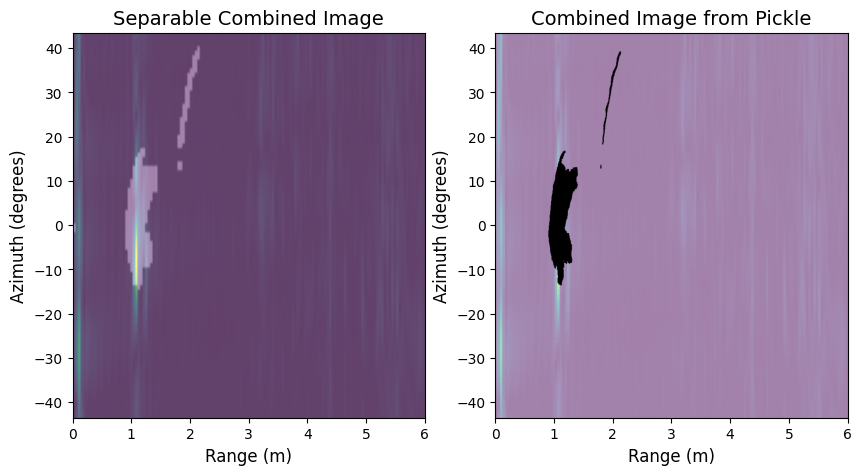

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import io
from loguru import logger

# Define depth camera configurations
depth_cam_config = {
    'd435': {
        'max_range': 3,
        'fov_azi': 69,
        'fov_ele': 42
    },
    'd455': {
        'max_range': 6,
        'fov_azi': 87,
        'fov_ele': 58
    }
}

# Select the camera type
type = 'd455'
depth_cam_config = depth_cam_config[type]

data_path = '/data/lucayu/lss-cfar/test/aaron_activity_room_2024-08-13_17-26-00.pickle'

# Load the pickle file
with open(data_path, 'rb') as f:
    data = pickle.load(f)

# Extract the spectrum and pointcloud data from the dictionary
processed_data = data['spectrum']
logger.info(f"Spectrum data shape: {processed_data.shape}")

pointcloud_image_binary = data['pointcloud']
combined_image_binary = data['combination']

# Load the pointcloud image from the binary data
pointcloud_image = Image.open(io.BytesIO(pointcloud_image_binary))

# Resize the PNG image to match the shape of processed_data
pointcloud_image_resized = pointcloud_image.resize((processed_data.shape[1], processed_data.shape[0]))
logger.info(f"Pointcloud image shape: {pointcloud_image_resized.size}")
pointcloud_image_resized = np.array(pointcloud_image_resized)
logger.info(f"Pointcloud image shape: {pointcloud_image_resized.shape}")
# ignore the alpha channel and if there has the color, turn it to 1, otherwise 0
pointcloud_image_resized = np.where(pointcloud_image_resized[:, :, 3] > 0, 1, 0)
logger.info(f"Pointcloud image shape: {pointcloud_image_resized.shape}")
# logger.info(np.where(pointcloud_image_resized == 1))

# Load the combined image from the binary data
combined_image = Image.open(io.BytesIO(combined_image_binary))

# Create a new figure with two subplots in a row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: Display the binarized PNG image (pointcloud) and overlay the spectrum
ax1.imshow(pointcloud_image_resized, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2], aspect='auto', alpha=0.5, cmap='gray')
ax1.imshow(processed_data, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2], aspect='auto', cmap='viridis', alpha=0.5)
ax1.set_xlabel("Range (m)", fontsize=12)
ax1.set_ylabel("Azimuth (degrees)", fontsize=12)
ax1.set_title("Separable Combined Image", fontsize=14)

# Second subplot: Display the combined image from the pickle file
ax2.imshow(combined_image, extent=[0, depth_cam_config['max_range'], -depth_cam_config['fov_azi'] / 2, depth_cam_config['fov_azi'] / 2], aspect='auto')
ax2.set_xlabel("Range (m)", fontsize=12)
ax2.set_ylabel("Azimuth (degrees)", fontsize=12)
ax2.set_title("Combined Image from Pickle", fontsize=14)

# Display the figure with both subplots
plt.show()
